In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_dir = '/home/guang/Projects/Cls./ai2-bird-recognition/train'
test_dir = '/home/guang/Projects/Cls./ai2-bird-recognition/val_and_test'
checkpoint_dir = '/home/guang/Projects/Cls./ai2-bird-recognition/checkpoints'
result_path = '/home/guang/Projects/Cls./ai2-bird-recognition/submission.csv'

In [3]:
# The "datasets" below open your images and preprocess them

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

In [4]:
# The data loaders below collect your images and put them into batches to feed the neural network 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [5]:
# Define a simple CNN architecture
class Simple_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Simple_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(8, 8, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
#             nn.Conv2d(16, 16, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
# Create a simple CNN
model = Simple_CNN()

# Create a ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Use cross-entropy loss
criterion = nn.CrossEntropyLoss()

In [8]:
def get_accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)

    _, pred = output.topk(1, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[0].view(-1).float().sum(0, keepdim=True)

    return correct_k.mul_(1.0 / batch_size).data[0]

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def train(model, data_loader, criterion, optimizer):
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    
    model.train() # switch to train mode
    for i, (input, target) in enumerate(data_loader):
        input, target = Variable(input), Variable(target)
        output = model(input)
        loss = criterion(output, target)
        
        optimizer.zero_grad() # clear the gradients computed before
        loss.backward() # compute the gradients using backward propagation
        optimizer.step() # update the parameters of the network
        
        accuracy = get_accuracy(output, target)
        loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
        print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
        loss_recorder.update(loss, input.size(0))
        accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [11]:
# def validate(model, data_loader, criterion):
#     loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
#     accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
#     model.eval() # switch to evaluation mode
#     for i, (input, target) in enumerate(data_loader):
#         input, target = Variable(input, volatile=True), Variable(target)
#         output = model(input)
#         loss = criterion(output, target)
        
#         accuracy = get_accuracy(output, target)
#         loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
#         print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
#         loss_recorder.update(loss, input.size(0))
#         accuracy_recorder.update(accuracy, input.size(0))
#     return loss_recorder.avg, accuracy_recorder.avg

In [12]:
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print('A checkpoint was saved to {}'.format(filename))

In [13]:
num_epochs = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    print('\nEpoch', epoch)
    
    print('---- train ----')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
        
    save_checkpoint(model.state_dict(), checkpoint_dir+'/checkpoint_epoch{}.pk'.format(epoch))


Epoch 1
---- train ----
Batch 1:	loss: 0.68849	 accuracy: 0.55000
Batch 2:	loss: 0.72636	 accuracy: 0.35000
Batch 3:	loss: 0.69699	 accuracy: 0.50000
Batch 4:	loss: 0.67994	 accuracy: 0.60000
Batch 5:	loss: 0.68756	 accuracy: 0.55000
Batch 6:	loss: 0.69460	 accuracy: 0.50000
Batch 7:	loss: 0.70304	 accuracy: 0.45000
Batch 8:	loss: 0.69578	 accuracy: 0.50000
Batch 9:	loss: 0.66144	 accuracy: 0.75000
Batch 10:	loss: 0.72795	 accuracy: 0.25000
A checkpoint was saved to /home/guang/Projects/Cls./ai2-bird-recognition/checkpoints/checkpoint_epoch1.pk

Epoch 2
---- train ----
Batch 1:	loss: 0.67071	 accuracy: 0.65000
Batch 2:	loss: 0.68487	 accuracy: 0.55000
Batch 3:	loss: 0.70923	 accuracy: 0.35000
Batch 4:	loss: 0.69793	 accuracy: 0.45000
Batch 5:	loss: 0.69435	 accuracy: 0.45000
Batch 6:	loss: 0.67748	 accuracy: 0.65000
Batch 7:	loss: 0.70708	 accuracy: 0.30000
Batch 8:	loss: 0.69162	 accuracy: 0.55000
Batch 9:	loss: 0.68975	 accuracy: 0.60000
Batch 10:	loss: 0.69050	 accuracy: 0.50000
A 

Batch 1:	loss: 0.63402	 accuracy: 0.80000
Batch 2:	loss: 0.69422	 accuracy: 0.60000
Batch 3:	loss: 0.54849	 accuracy: 0.80000
Batch 4:	loss: 0.59014	 accuracy: 0.80000
Batch 5:	loss: 0.63131	 accuracy: 0.70000
Batch 6:	loss: 0.68154	 accuracy: 0.55000
Batch 7:	loss: 0.59386	 accuracy: 0.65000
Batch 8:	loss: 0.55533	 accuracy: 0.75000
Batch 9:	loss: 0.60062	 accuracy: 0.65000
Batch 10:	loss: 0.58969	 accuracy: 0.65000
A checkpoint was saved to /home/guang/Projects/Cls./ai2-bird-recognition/checkpoints/checkpoint_epoch16.pk

Epoch 17
---- train ----
Batch 1:	loss: 0.57308	 accuracy: 0.70000
Batch 2:	loss: 0.67869	 accuracy: 0.55000
Batch 3:	loss: 0.61254	 accuracy: 0.75000
Batch 4:	loss: 0.62424	 accuracy: 0.80000
Batch 5:	loss: 0.69464	 accuracy: 0.55000
Batch 6:	loss: 0.59844	 accuracy: 0.75000
Batch 7:	loss: 0.64673	 accuracy: 0.55000
Batch 8:	loss: 0.47964	 accuracy: 0.75000
Batch 9:	loss: 0.52961	 accuracy: 0.80000
Batch 10:	loss: 0.68769	 accuracy: 0.50000
A checkpoint was saved to

Batch 1:	loss: 0.53776	 accuracy: 0.80000
Batch 2:	loss: 0.36393	 accuracy: 0.85000
Batch 3:	loss: 0.52128	 accuracy: 0.80000
Batch 4:	loss: 0.38074	 accuracy: 0.90000
Batch 5:	loss: 0.55862	 accuracy: 0.75000
Batch 6:	loss: 0.39056	 accuracy: 0.85000
Batch 7:	loss: 0.38682	 accuracy: 0.90000
Batch 8:	loss: 0.53470	 accuracy: 0.85000
Batch 9:	loss: 0.33130	 accuracy: 0.85000
Batch 10:	loss: 0.63829	 accuracy: 0.65000
A checkpoint was saved to /home/guang/Projects/Cls./ai2-bird-recognition/checkpoints/checkpoint_epoch31.pk

Epoch 32
---- train ----
Batch 1:	loss: 0.41507	 accuracy: 0.80000
Batch 2:	loss: 0.56275	 accuracy: 0.75000
Batch 3:	loss: 0.28033	 accuracy: 0.95000
Batch 4:	loss: 0.61331	 accuracy: 0.75000
Batch 5:	loss: 0.37105	 accuracy: 0.85000
Batch 6:	loss: 0.61521	 accuracy: 0.65000
Batch 7:	loss: 0.42937	 accuracy: 0.85000
Batch 8:	loss: 0.39740	 accuracy: 0.85000
Batch 9:	loss: 0.42287	 accuracy: 0.80000
Batch 10:	loss: 0.53913	 accuracy: 0.80000
A checkpoint was saved to

Batch 1:	loss: 0.34852	 accuracy: 0.90000
Batch 2:	loss: 0.33506	 accuracy: 0.85000
Batch 3:	loss: 0.38093	 accuracy: 0.80000
Batch 4:	loss: 0.32927	 accuracy: 0.85000
Batch 5:	loss: 0.38114	 accuracy: 0.85000
Batch 6:	loss: 0.32089	 accuracy: 0.90000
Batch 7:	loss: 0.29274	 accuracy: 0.95000
Batch 8:	loss: 0.20391	 accuracy: 0.95000
Batch 9:	loss: 0.36891	 accuracy: 0.85000
Batch 10:	loss: 0.35869	 accuracy: 0.70000
A checkpoint was saved to /home/guang/Projects/Cls./ai2-bird-recognition/checkpoints/checkpoint_epoch46.pk

Epoch 47
---- train ----
Batch 1:	loss: 0.22576	 accuracy: 0.95000
Batch 2:	loss: 0.28963	 accuracy: 0.85000
Batch 3:	loss: 0.56426	 accuracy: 0.75000
Batch 4:	loss: 0.31006	 accuracy: 0.85000
Batch 5:	loss: 0.25637	 accuracy: 0.95000
Batch 6:	loss: 0.45339	 accuracy: 0.80000
Batch 7:	loss: 0.22972	 accuracy: 0.90000
Batch 8:	loss: 0.31473	 accuracy: 0.80000
Batch 9:	loss: 0.23843	 accuracy: 0.95000
Batch 10:	loss: 0.22917	 accuracy: 0.90000
A checkpoint was saved to

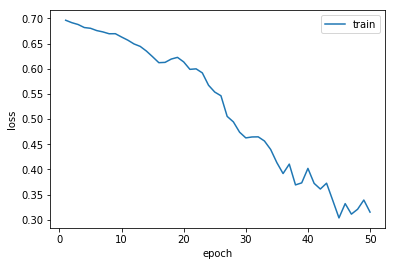

In [14]:
plt.figure()
plt.plot(np.arange(num_epochs)+1, train_losses)
#plt.plot(np.arange(num_epochs)+1, val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

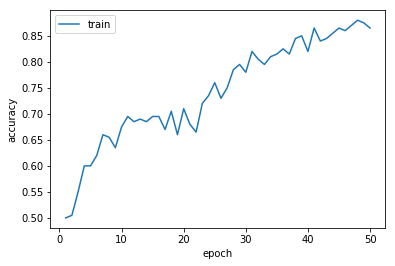

In [15]:
plt.figure()
plt.plot(np.arange(num_epochs)+1, train_accuracies)
#plt.plot(np.arange(num_epochs)+1, val_accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])

Choose a model that you like best

In [16]:
prefered_checkpoint = '/home/guang/Projects/Cls./ai2-bird-recognition/checkpoints/checkpoint_epoch50.pk'
model.load_state_dict(torch.load(prefered_checkpoint))

Let your AI automatically recognize if there are birds in each images in test set

In [17]:
images = []
preds = []
model.eval()
for i, (input, target) in enumerate(tqdm(test_loader)):
    input, target = Variable(input, volatile=True), Variable(target)
    output = model(input)
    confidence = nn.functional.softmax(output, dim=1)
    confidence = confidence.cpu().data[0].numpy()
    if confidence[0] >= 0.5: # If the network predicts that the image contains a bird
        pred = 1
    else:
        pred = 0
    preds.append(pred)
    
    # Get the file name of the current image
    image = test_dataset.imgs[i]
    image = os.path.basename(image[0])
    images.append(image)
submission = pd.DataFrame({'image': images, 'has_bird': preds}, columns=['image', 'has_bird'])

100%|██████████| 200/200 [00:01<00:00, 177.13it/s]


Take a look at the first rows of the result.

In [18]:
submission.head()

,image,has_bird
0,0000.JPG,1
1,0001.JPG,0
2,0002.JPG,1
3,0003.JPG,1
4,0004.JPG,0


In [19]:
submission.to_csv(result_path, index=False)